<a href="https://colab.research.google.com/github/JVR27XD/SAM/blob/main/MobileSAM1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- Montar Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- (Opcional) Limpiar salida ---
import os, sys, warnings
warnings.filterwarnings("ignore")

# --- Comprobar GPU ---
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


Mounted at /content/drive


device(type='cuda')

In [ ]:

#  Clonar MobileSAM
import os
if not os.path.exists("MobileSAM"):
    !git clone https://github.com/ChaoningZhang/MobileSAM.git
%cd MobileSAM
# --- Arreglar import de mobile_sam en Colab ---
import sys, os, shutil, importlib

repo_dir = "/content/MobileSAM"
pkg_dir  = "/content/MobileSAM"  # la carpeta 'mobile_sam' está dentro de aquí

# 1) Asegura que la ruta del repo está al principio del PYTHONPATH
if pkg_dir not in sys.path:
    sys.path.insert(0, pkg_dir)

# 2) Limpia posibles cachés que confundan el import
for d in [os.path.join(repo_dir, "__pycache__"),
          os.path.join(repo_dir, "mobile_sam", "__pycache__")]:
    if os.path.isdir(d):
        shutil.rmtree(d, ignore_errors=True)

# 3) Instala el repo como paquete editable (import seguro)
!pip -q install -e /content/MobileSAM

# 4) Comprueba que existe el módulo y haz el import
import pathlib
print("Contenido de /content/MobileSAM:", [p.name for p in pathlib.Path(repo_dir).iterdir()])
print("¿Existe carpeta 'mobile_sam'? ->", os.path.isdir(os.path.join(repo_dir, "mobile_sam")))

# 5) Importa ahora
from mobile_sam import sam_model_registry
import torch

# 6) Carga el modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights_path = "/content/MobileSAM/weights/mobile_sam.pt"
assert os.path.exists(weights_path), f"No se encuentra el checkpoint en {weights_path}"

mobile_sam = sam_model_registry["vit_t"](checkpoint=weights_path).to(device)
mobile_sam.eval()
print("✅ Import y carga correctos. Device:", device)



Cloning into 'MobileSAM'...
remote: Enumerating objects: 1011, done.
remote: Counting objects: 100% (407/407), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 1011 (delta 347), reused 272 (delta 271), pack-reused 604 (from 1)
Receiving objects: 100% (1011/1011), 95.44 MiB | 26.97 MiB/s, done.
Resolving deltas: 100% (461/461), done.
/content/MobileSAM/MobileSAM
  Preparing metadata (setup.py) ... done
Contenido de /content/MobileSAM: ['scripts', 'weights', 'Member.txt', 'assets', 'linter.sh', 'LICENSE', 'README.md', 'setup.py', '.gitignore', 'mobile_sam.egg-info', 'mobile_sam', 'MobileSAM', 'CODE_OF_CONDUCT.md', 'MobileSAMv2', 'CONTRIBUTING.md', 'setup.cfg', '.git', 'notebooks', 'app']
¿Existe carpeta 'mobile_sam'? -> True
✅ Import y carga correctos. Device: cuda


In [ ]:
# --- Rutas de proyecto ---
base_dir = "/content/drive/MyDrive/Colab Notebooks/SolDef_AI"
labeled_dir = os.path.join(base_dir, "Labeled")
mask_output_dir = os.path.join(labeled_dir, "generated_masks")
os.makedirs(mask_output_dir, exist_ok=True)

print("📂 Base:", base_dir)
print("📂 Labeled:", labeled_dir)
print("📂 Masks out:", mask_output_dir)


📂 Base: /content/drive/MyDrive/Colab Notebooks/SolDef_AI
📂 Labeled: /content/drive/MyDrive/Colab Notebooks/SolDef_AI/Labeled
📂 Masks out: /content/drive/MyDrive/Colab Notebooks/SolDef_AI/Labeled/generated_masks


In [ ]:
import json
import numpy as np
from PIL import Image, ImageDraw

def scale_polygon(points, original_width, original_height, target_width, target_height):
    """Reescala puntos del espacio (ann_w, ann_h) al espacio (img_w, img_h)."""
    sx = target_width / float(original_width)  if original_width  else 1.0
    sy = target_height / float(original_height) if original_height else 1.0
    return [(x * sx, y * sy) for (x, y) in points]

def clamp_points(points, W, H):
    """Clampa y castea a int para estabilidad al dibujar en máscara."""
    return [
        (int(max(0, min(W - 1, x))),
         int(max(0, min(H - 1, y))))
        for x, y in points
    ]

# --- Explorar JSONs, generar máscaras 0/255 y construir listas alineadas ---
image_paths, mask_paths = [], []
json_files = sorted(f for f in os.listdir(labeled_dir) if f.endswith(".json"))

skipped = 0
for jf in json_files:
    jp = os.path.join(labeled_dir, jf)
    with open(jp, "r") as f:
        data = json.load(f)

    image_name = data.get("imagePath")
    if not image_name:
        skipped += 1
        continue

    ipath = os.path.join(labeled_dir, image_name)
    if not os.path.exists(ipath):
        print(f"⚠️ Imagen no encontrada para {jf}: {image_name}")
        skipped += 1
        continue

    img = Image.open(ipath).convert("RGB")
    W, H = img.size

    ann_w = data.get("imageWidth", W)
    ann_h = data.get("imageHeight", H)

    # Crear máscara 0/255
    mask = Image.new("L", (W, H), 0)
    draw = ImageDraw.Draw(mask)

    for shape in data.get("shapes", []):
        pts = shape.get("points", [])
        if not pts:
            continue

        # Si shape_type fuera 'rectangle', convertir a polígono (opcional)
        # if shape.get("shape_type") == "rectangle" and len(pts) == 2:
        #     (x1,y1), (x2,y2) = pts
        #     pts = [(x1,y1),(x2,y1),(x2,y2),(x1,y2)]

        scaled = scale_polygon(pts, ann_w, ann_h, W, H)
        scaled = clamp_points(scaled, W, H)
        draw.polygon(scaled, outline=255, fill=255)

    mname = os.path.splitext(image_name)[0] + "_mask.png"
    mpath = os.path.join(mask_output_dir, mname)
    mask.save(mpath)

    image_paths.append(ipath)
    mask_paths.append(mpath)

print(f"✅ Máscaras generadas: {len(mask_paths)} | JSONs omitidos: {skipped}")
assert len(image_paths) == len(mask_paths) and len(image_paths) > 0, "No hay pares imagen-máscara válidos."


✅ Máscaras generadas: 428 | JSONs omitidos: 0


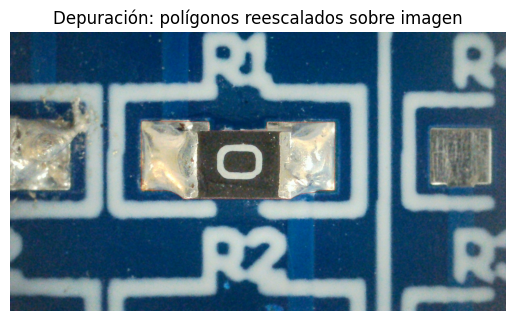

In [ ]:
# Visualiza polígonos reescalados sobre la imagen original
import matplotlib.pyplot as plt

sample_idx = 0  # cambia el índice si quieres otra imagen
debug_image_path = image_paths[sample_idx]
debug_json_name = os.path.splitext(os.path.basename(debug_image_path))[0] + ".json"
debug_json_path = os.path.join(labeled_dir, debug_json_name)

with open(debug_json_path, "r") as f:
    data = json.load(f)

img = Image.open(debug_image_path).convert("RGB")
W, H = img.size
ann_w = data.get("imageWidth", W)
ann_h = data.get("imageHeight", H)

dbg = img.copy()
d = ImageDraw.Draw(dbg)

for shape in data.get("shapes", []):
    pts = shape.get("points", [])
    if not pts:
        continue
    scaled = clamp_points(scale_polygon(pts, ann_w, ann_h, W, H), W, H)
    d.polygon(scaled, outline="red")

plt.imshow(dbg)
plt.title("Depuración: polígonos reescalados sobre imagen")
plt.axis("off")
plt.show()


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision.transforms.functional import pil_to_tensor

# Normalización SAM (en 0-255)
MEAN = [123.675, 116.28, 103.53]
STD  = [58.395, 57.12, 57.375]

import torchvision.transforms as T
sam_transform = T.Compose([
    T.ToTensor(),                 # [0,1]
    T.Lambda(lambda t: t*255.0),  # [0,255]
    T.Normalize(mean=MEAN, std=STD),
])

# Redefine un dataset que NO transforma (devuelve PIL)
from torch.utils.data import Dataset

class PCBDefectDatasetRaw(Dataset):
    def __init__(self, image_paths, mask_paths):
        assert len(image_paths) == len(mask_paths)
        self.image_paths = image_paths
        self.mask_paths = mask_paths
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img = PILImage.open(self.image_paths[idx]).convert("RGB")
        msk = PILImage.open(self.mask_paths[idx]).convert("L")
        return img, msk, self.image_paths[idx]

eval_loader = DataLoader(
    PCBDefectDatasetRaw(image_paths, mask_paths),
    batch_size=1, shuffle=False, num_workers=0,  # pon 0 si estás en CPU
    pin_memory=torch.cuda.is_available(),
    collate_fn=lambda x: x
)

# Chequeo rápido
img_t, m_t, pth = next(iter(dataloader))
print("Imagen:", img_t.shape, img_t.dtype, "Máscara:", m_t.shape, m_t.unique())


Imagen: torch.Size([1, 3, 1440, 2560]) torch.float32 Máscara: torch.Size([1, 1, 1440, 2560]) tensor([0., 1.])


In [ ]:
import numpy as np
from sklearn.metrics import jaccard_score, precision_score, recall_score

def dice_coef_np(y_true, y_pred):
    # y_true, y_pred: arrays 0/1
    inter = np.sum(y_true * y_pred)
    return 2. * inter / (np.sum(y_true) + np.sum(y_pred) + 1e-7)


In [ ]:
from PIL import Image

def preprocess_to_1024(image_pil, mask_pil):
    """Redimensiona imagen (bilinear) y máscara (nearest) a 1024x1024 + normaliza imagen con SAM."""
    img_resized = image_pil.resize((1024, 1024), resample=Image.BILINEAR)
    mask_resized = mask_pil.resize((1024, 1024), resample=Image.NEAREST)
    # Normalización SAM:
    img_tensor = sam_transform(img_resized).unsqueeze(0).to(device)  # (1,3,1024,1024)
    return img_tensor, (np.array(mask_resized) > 127)

def encode_image(mobile_sam, input_tensor):
    with torch.no_grad():
        return mobile_sam.image_encoder(input_tensor)

def decode_mask(mobile_sam, image_embedding, sparse_embeddings, dense_embeddings):
    with torch.no_grad():
        low_res_masks, _ = mobile_sam.mask_decoder(
            image_embeddings=image_embedding,
            image_pe=mobile_sam.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
        )
        masks = torch.nn.functional.interpolate(
            low_res_masks, size=(1024, 1024), mode="bilinear", align_corners=False
        )
        prob = masks.sigmoid()[0, 0].cpu().numpy()
        return (prob > 0.5)  # binaria


In [ ]:
# === Dataset RAW (devuelve PIL, sin transform) ===
from torch.utils.data import Dataset, DataLoader
from PIL import Image as PILImage

class PCBDefectDatasetRaw(Dataset):
    def __init__(self, image_paths, mask_paths):
        assert len(image_paths) == len(mask_paths)
        self.image_paths = image_paths
        self.mask_paths = mask_paths
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img = PILImage.open(self.image_paths[idx]).convert("RGB")
        msk = PILImage.open(self.mask_paths[idx]).convert("L")
        return img, msk, self.image_paths[idx]

import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

prompt_types = ["point", "box", "box+point", "multipoint"]
results = {k: {"ious": [], "dices": [], "precs": [], "recs": [], "times": [], "vrams": [], "last_pred": None}
           for k in prompt_types}

# Reproducibilidad en multipoint
rng = np.random.default_rng(0)

print("\n🚀 Evaluando MobileSAM con 4 tipos de prompt...\n")
save_vis = True
os.makedirs("/content/resultados_pred", exist_ok=True)

# ⚠️ Usamos el dataset RAW para que image_pil/mark_pil sean PIL
eval_loader = DataLoader(
    PCBDefectDatasetRaw(image_paths, mask_paths),
    batch_size=1,
    shuffle=False,
    num_workers=0 if (not torch.cuda.is_available()) else 2,
    pin_memory=torch.cuda.is_available(),
    collate_fn=lambda x: x
)

for i, batch in enumerate(tqdm(eval_loader)):
    # batch es lista de tuplas (imagen_PIL, máscara_PIL, ruta)
    image_pil, mask_pil, path = batch[0]
    orig_w, orig_h = image_pil.size  # ✅ ahora es una tupla (W,H)

    # GT original -> coords
    gt_mask = (np.array(mask_pil) > 127)
    coords = np.argwhere(gt_mask)  # (y,x)
    if coords.size == 0:
        print(f"⚠️ Sin anotación en: {path}")
        continue

    # bbox + centro en original
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    y_c, x_c = coords.mean(axis=0).astype(int)

    # Preprocesar a 1024 (imagen y GT)  -> usa tus funciones ya definidas
    input_tensor, gt_1024 = preprocess_to_1024(image_pil, mask_pil)
    image_embedding = encode_image(mobile_sam, input_tensor)
    y_true = gt_1024.flatten().astype(np.uint8)

    # Escalas (original -> 1024)
    scale_x = 1024.0 / float(orig_w)
    scale_y = 1024.0 / float(orig_h)

    for method in prompt_types:
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats(device)

        start = time.time()

        if method == "point":
            input_point = np.array([[x_c * scale_x, y_c * scale_y]], dtype=np.float32)
            input_label = np.array([1], dtype=np.int64)
            pt = torch.tensor(input_point, dtype=torch.float32, device=device)[None, :, :]
            lb = torch.tensor(input_label, dtype=torch.int64, device=device)[None, :]
            with torch.no_grad():
                se, de = mobile_sam.prompt_encoder(points=(pt, lb), boxes=None, masks=None)

        elif method == "box":
            box = np.array([[x_min * scale_x, y_min * scale_y, x_max * scale_x, y_max * scale_y]], dtype=np.float32)
            bt = torch.tensor(box, dtype=torch.float32, device=device)[None, :, :]
            with torch.no_grad():
                se, de = mobile_sam.prompt_encoder(points=None, boxes=bt, masks=None)

        elif method == "box+point":
            input_point = np.array([[x_c * scale_x, y_c * scale_y]], dtype=np.float32)
            input_label = np.array([1], dtype=np.int64)
            box = np.array([[x_min * scale_x, y_min * scale_y, x_max * scale_x, y_max * scale_y]], dtype=np.float32)
            pt = torch.tensor(input_point, dtype=torch.float32, device=device)[None, :, :]
            lb = torch.tensor(input_label, dtype=torch.int64, device=device)[None, :]
            bt = torch.tensor(box, dtype=torch.float32, device=device)[None, :, :]
            with torch.no_grad():
                se, de = mobile_sam.prompt_encoder(points=(pt, lb), boxes=bt, masks=None)

        elif method == "multipoint":
            n_points = min(5, len(coords))
            sampled = coords[rng.choice(len(coords), size=n_points, replace=False)]
            # (x,y) en 1024
            pts = np.stack([sampled[:, 1] * scale_x, sampled[:, 0] * scale_y], axis=1).astype(np.float32)
            labels = np.ones(n_points, dtype=np.int64)
            pt = torch.tensor(pts, dtype=torch.float32, device=device)[None, :, :]
            lb = torch.tensor(labels, dtype=torch.int64, device=device)[None, :]
            with torch.no_grad():
                se, de = mobile_sam.prompt_encoder(points=(pt, lb), boxes=None, masks=None)

        # Decodificar (usa tu helper)
        pred_mask = decode_mask(mobile_sam, image_embedding, se, de)
        elapsed = time.time() - start

        y_pred = pred_mask.flatten().astype(np.uint8)

        # Métricas (usa tus funcs ya importadas/definidas)
        results[method]["ious"].append(jaccard_score(y_true, y_pred, zero_division=0))
        results[method]["dices"].append(dice_coef_np(y_true, y_pred))
        results[method]["precs"].append(precision_score(y_true, y_pred, zero_division=0))
        results[method]["recs"].append(recall_score(y_true, y_pred, zero_division=0))
        results[method]["times"].append(elapsed)
        if torch.cuda.is_available():
            vram = torch.cuda.max_memory_allocated(device) / 1024**2
            results[method]["vrams"].append(vram)
        results[method]["last_pred"] = pred_mask

        # Guardar algunas predicciones
        if save_vis and i < 5:
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            axes[0].imshow(image_pil)
            axes[0].set_title("Imagen")
            axes[1].imshow(gt_1024, cmap='gray')
            axes[1].set_title("GT 1024")
            axes[2].imshow(pred_mask, cmap='gray')
            axes[2].set_title(f"Pred ({method})")
            for ax in axes: ax.axis("off")
            plt.tight_layout()
            outp = f"/content/resultados_pred/pred_{i}_{method}.png"
            plt.savefig(outp, dpi=150)
            plt.close()

print("✅ Evaluación completada.")



🚀 Evaluando MobileSAM con 4 tipos de prompt...



100%|██████████| 428/428 [08:58<00:00,  1.26s/it]

✅ Evaluación completada.


In [ ]:
import numpy as np

print("\n📊 MÉTRICAS PROMEDIO Y VARIABILIDAD:")
for method in prompt_types:
    if len(results[method]['ious']) == 0:
        print(f"\n🧐 {method.upper()} (sin muestras)")
        continue

    miou  = np.mean(results[method]['ious'])
    siou  = np.std(results[method]['ious'])
    mdice = np.mean(results[method]['dices'])
    sdice = np.std(results[method]['dices'])
    mpre  = np.mean(results[method]['precs'])
    spre  = np.std(results[method]['precs'])
    mrec  = np.mean(results[method]['recs'])
    srec  = np.std(results[method]['recs'])
    mtime = np.mean(results[method]['times'])

    print(f"\n🧐 {method.upper()}")
    print(f"IoU: {miou:.4f} ± {siou:.4f}")
    print(f"Dice: {mdice:.4f} ± {sdice:.4f}")
    print(f"Precisión: {mpre:.4f} ± {spre:.4f}")
    print(f"Recall: {mrec:.4f} ± {srec:.4f}")
    print(f"⏱️ Tiempo promedio: {mtime:.4f} s")
    print(f"⚡ FPS: {1.0/mtime:.2f}")
    if torch.cuda.is_available() and len(results[method]['vrams']) > 0:
        print(f"📊 VRAM promedio: {np.mean(results[method]['vrams']):.2f} MB")



📊 MÉTRICAS PROMEDIO Y VARIABILIDAD:

🧐 POINT
IoU: 0.2565 ± 0.2502
Dice: 0.3513 ± 0.2916
Precisión: 0.6240 ± 0.4204
Recall: 0.3394 ± 0.3278
⏱️ Tiempo promedio: 0.0664 s
⚡ FPS: 15.05
📊 VRAM promedio: 101.91 MB

🧐 BOX
IoU: 0.7257 ± 0.2610
Dice: 0.8127 ± 0.1881
Precisión: 0.7400 ± 0.2670
Recall: 0.9722 ± 0.0424
⏱️ Tiempo promedio: 0.0100 s
⚡ FPS: 99.51
📊 VRAM promedio: 101.91 MB

🧐 BOX+POINT
IoU: 0.7268 ± 0.2610
Dice: 0.8135 ± 0.1880
Precisión: 0.7397 ± 0.2671
Recall: 0.9751 ± 0.0342
⏱️ Tiempo promedio: 0.0111 s
⚡ FPS: 89.90
📊 VRAM promedio: 101.92 MB

🧐 MULTIPOINT
IoU: 0.6901 ± 0.2482
Dice: 0.7901 ± 0.1814
Precisión: 0.7438 ± 0.2619
Recall: 0.9313 ± 0.1302
⏱️ Tiempo promedio: 0.0114 s
⚡ FPS: 87.85
📊 VRAM promedio: 101.94 MB


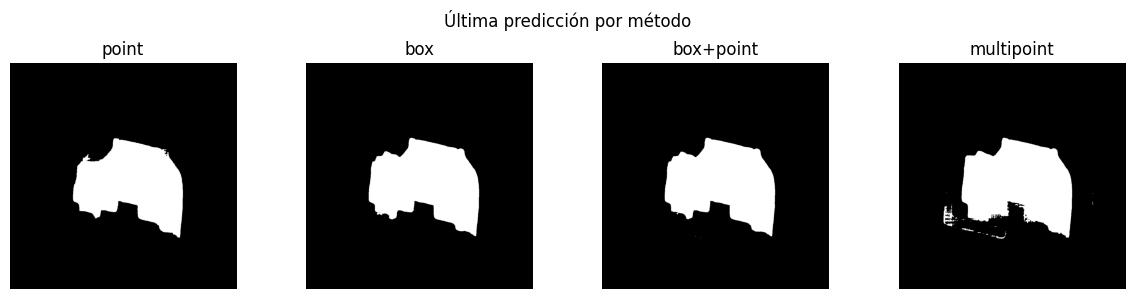

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,3))
for j, method in enumerate(prompt_types):
    plt.subplot(1, 4, j+1)
    pm = results[method]["last_pred"]
    if pm is None:
        plt.text(0.5, 0.5, "N/A", ha="center", va="center")
        plt.axis("off"); plt.title(method); continue
    plt.imshow(pm, cmap='gray')
    plt.axis("off")
    plt.title(method)
plt.suptitle("Última predicción por método")
plt.tight_layout()
plt.show()


In [ ]:
# === Resumen del PROCESO DE DATOS: impresión y guardado (añadir al notebook) ===
import json, os, datetime, platform
import torch

data_process_config = {
    "dataset_source": "LabelMe-like JSON en base_dir/Labeled",
    "mask_generation": {
        "from": "shapes.points (polígonos)",
        "scale_to_image_size": True,
        "scale_fields_used": ["imageWidth","imageHeight","imagePath"],
        "clamp_and_int": True,
        "mode": "PIL 'L' (8-bit)",
        "values": {"background": 0, "foreground": 255},
        "save_dir": "generated_masks",
        "binarization_after_load": "mask_tensor = (mask > 127.5).float()  # 0/1"
    },
    "image_preprocess_1024": {
        "resize_image": "BILINEAR to 1024x1024",
        "resize_mask": "NEAREST to 1024x1024",
        "normalization_SAM": {
            "scale": "[0,1] -> *255",
            "mean": [123.675, 116.28, 103.53],
            "std":  [58.395, 57.12, 57.375]
        }
    },
    "prompts": {
        "coordinate_order": "(x, y)",
        "scales": {"scale_x": "1024/orig_w", "scale_y": "1024/orig_h"},
        "types": {
            "point": "centroide de GT",
            "box": "bbox (min/max) de GT",
            "box+point": "bbox + centroide",
            "multipoint": "hasta 5 puntos muestreados dentro de GT (semilla fija)"
        },
        "dtypes": {"points": "float32", "labels": "int64"}
    },
    "evaluation": {
        "metrics": ["IoU (jaccard_score)", "Dice (custom)", "Precision", "Recall"],
        "threshold": "0.5 (sigmoid > 0.5)",
        "timing": True,
        "vram_peak": "torch.cuda.max_memory_allocated"
    },
    "reproducibility": {
        "rng_seed_multipoint": 0,
        "sorted_json_listing": True
    },
    "environment": {
        "device": str(device),
        "torch": torch.__version__,
        "python": platform.python_version(),
        "timestamp": datetime.datetime.now().isoformat()
    }
}

def print_data_process_summary(cfg):
    print("\n================= RESUMEN PROCESO DE DATOS =================")
    print(f"- Origen dataset: {cfg['dataset_source']}")
    print(f"- Máscaras: escala polígonos -> clamp/int -> PIL 'L' 0/255 -> binarización >127.5 -> 0/1")
    print(f"- Imagen: resize BILINEAR 1024x1024 + normalización SAM (0–255, mean/std de SAM)")
    print(f"- GT: resize NEAREST 1024x1024 (sin interpolación de grises)")
    print(f"- Prompts: orden (x,y), escalas (1024/orig_w, 1024/orig_h); dtypes float32/int64")
    print(f"- Tipos de prompt: point | box | box+point | multipoint (semilla {cfg['reproducibility']['rng_seed_multipoint']})")
    print(f"- Umbral: sigmoid > 0.5; Métricas: IoU, Dice, Precisión, Recall; Tiempo y VRAM")
    print(f"- Device: {cfg['environment']['device']} | Torch: {cfg['environment']['torch']} | Python: {cfg['environment']['python']}")
    print("============================================================\n")

# imprimir y guardar
print_data_process_summary(data_process_config)
os.makedirs("/content/resultados_pred", exist_ok=True)
with open("/content/resultados_pred/preprocessing_report.json", "w") as f:
    json.dump(data_process_config, f, indent=2, ensure_ascii=False)
print("📝 Guardado:", "/content/resultados_pred/preprocessing_report.json")



================= RESUMEN PROCESO DE DATOS =================
- Origen dataset: LabelMe-like JSON en base_dir/Labeled
- Máscaras: escala polígonos -> clamp/int -> PIL 'L' 0/255 -> binarización >127.5 -> 0/1
- Imagen: resize BILINEAR 1024x1024 + normalización SAM (0–255, mean/std de SAM)
- GT: resize NEAREST 1024x1024 (sin interpolación de grises)
- Prompts: orden (x,y), escalas (1024/orig_w, 1024/orig_h); dtypes float32/int64
- Tipos de prompt: point | box | box+point | multipoint (semilla 0)
- Umbral: sigmoid > 0.5; Métricas: IoU, Dice, Precisión, Recall; Tiempo y VRAM
- Device: cuda | Torch: 2.6.0+cu124 | Python: 3.11.13

📝 Guardado: /content/resultados_pred/preprocessing_report.json
